In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import tensorflow as tf
from PIL import Image
from io import BytesIO
from six.moves import urllib
from tensorflow.keras.applications import inception_v3, InceptionV3
tf.__version__

'2.1.0'

## Inception V3 architecture to predict ImageNet classes

see 

- https://github.com/tensorflow/models/tree/master/research/inception
- https://medium.com/@utsumuki_neko/using-inception-v3-from-tensorflow-hub-for-transfer-learning-a931ff884526


In [2]:
model = InceptionV3(weights='imagenet', include_top=True)

96116736/96112376 [==============================] - 10s 0us/step


In [3]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [114]:
k = model.get_layer("input_1")
k.input

<tf.Tensor 'input_1:0' shape=(None, 299, 299, 3) dtype=float32>

In [115]:
k = model.get_weights()

In [116]:
from skimage.transform import resize
img = plt.imread("local/imgs/french-horn.jpg")
img = resize(img, output_shape=(299,299,3))
img.shape, np.min(img),np.max(img)

((299, 299, 3), 0.0, 1.0)

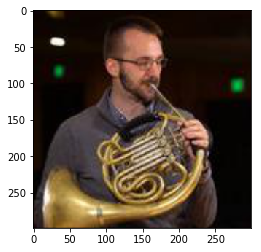

In [117]:
plt.imshow(img)

### predict and decode

In [118]:
pred = model.predict(img.reshape(-1,*img.shape))
pred.shape

(1, 1000)

In [119]:
print ("highest probabilities", np.sort(pred[0])[::-1][:10])
print ("highest class codes  ", np.argsort(pred[0])[::-1][:10])

highest probabilities [9.8343211e-01 5.5824034e-04 4.9936055e-04 3.5180591e-04 1.8363049e-04
 1.7420821e-04 1.6595154e-04 1.5756978e-04 1.3450027e-04 1.3397845e-04]
highest class codes   [566 683 432 262 676 513 639  10  57  70]


In [120]:
from tensorflow.keras.applications.inception_v3 import decode_predictions

print ('Predicted:')
k = decode_predictions(pred, top=100)[0]
for i in k:
    print("%10s %20s %.6f"%i)


Predicted:
 n03394916          French_horn 0.983432
 n03838899                 oboe 0.000558
 n02804610              bassoon 0.000499
 n02112706    Brabancon_griffon 0.000352
 n03803284               muzzle 0.000184
 n03110669               cornet 0.000174
 n03710721              maillot 0.000166
 n01530575            brambling 0.000158
 n01735189         garter_snake 0.000135
 n01770081           harvestman 0.000134
 n01930112             nematode 0.000126
 n07831146            carbonara 0.000082
 n01770393             scorpion 0.000077
 n04086273             revolver 0.000066
 n04579432              whistle 0.000065
 n02669723        academic_gown 0.000060
 n02106550           Rottweiler 0.000059
 n03777754                modem 0.000059
 n03017168                chime 0.000058
 n04152593               screen 0.000058
 n04116512        rubber_eraser 0.000058
 n03944341             pinwheel 0.000058
 n01685808             whiptail 0.000057
 n02396427            wild_boar 0.000055
 n078

### occlusion at random

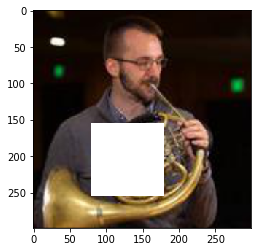

In [121]:
oimg = img.copy()
w,h=100,100
bx,by = np.random.randint(img.shape[1]-w), np.random.randint(img.shape[0]-h)
#bx,by=100,140
#bx,by=20,90
oimg[by:by+h,bx:bx+w]=np.max(oimg)
p = oimg[by:by+h,bx:bx+w,:]
plt.imshow(oimg)

observe how prediction probabilities change when occlusion happens on the key object. Try also the following:

- bx=80 and by=80
- bx=20 and by=90 

what part of the instrument is more responsible for the CNN classification?

In [95]:
pred = model.predict(oimg.reshape(-1,*oimg.shape))
print ('Predicted:', decode_predictions(pred, top=5))

Predicted: [[('n03394916', 'French_horn', 0.30430397), ('n03110669', 'cornet', 0.12212477), ('n02804610', 'bassoon', 0.120182335), ('n02815834', 'beaker', 0.036661845), ('n04560804', 'water_jug', 0.030287847)]]


In [98]:
decode_predictions(pred, top=100)

[[('n03394916', 'French_horn', 0.30430397),
  ('n03110669', 'cornet', 0.12212477),
  ('n02804610', 'bassoon', 0.120182335),
  ('n02815834', 'beaker', 0.036661845),
  ('n04560804', 'water_jug', 0.030287847),
  ('n04141076', 'sax', 0.029329153),
  ('n04487394', 'trombone', 0.024987357),
  ('n03838899', 'oboe', 0.011708039),
  ('n04579145', 'whiskey_jug', 0.01167778),
  ('n07932039', 'eggnog', 0.006394651),
  ('n04296562', 'stage', 0.006048563),
  ('n02916936', 'bulletproof_vest', 0.005379889),
  ('n02895154', 'breastplate', 0.0047482154),
  ('n03920288', 'Petri_dish', 0.0037513862),
  ('n04443257', 'tobacco_shop', 0.0035914204),
  ('n02669723', 'academic_gown', 0.0034471273),
  ('n02112706', 'Brabancon_griffon', 0.003387906),
  ('n03950228', 'pitcher', 0.0028299456),
  ('n03868863', 'oxygen_mask', 0.002770064),
  ('n03595614', 'jersey', 0.0025977287),
  ('n02823750', 'beer_glass', 0.0024363222),
  ('n04557648', 'water_bottle', 0.0024345685),
  ('n04579432', 'whistle', 0.0024121809),
  ('